# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
set_config(transform_output='pandas')


tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

tf.config.experimental.enable_op_determinism()

# Data
- Making a mulit-class text classification to match each passage to the correct author.
- ['Spooky'](https://drive.google.com/file/d/1uUtuiAM1AqGvDMrd3-L8vLFfHPrt3pWG/view?usp=sharing) dataset.
    - Passages from three famaous authors:
        - Edgar Allan Poe
        - HP Lovecraft
        - Mary Shelley

In [2]:
# Load Data from Data folder
df = pd.read_csv('Data/spooky.csv', index_col='id')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 19579 entries, id26305 to id00393
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19579 non-null  object
 1   author  19579 non-null  object
dtypes: object(2)
memory usage: 458.9+ KB


,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


- Want to look at the length of each text
- Using lambda function to split on space and get the length
- Using .describe to get statics on length

In [3]:
# Making new column to hold length 
df['sequence_length'] = df['text'].map(lambda x: len(x.split(' ')))
df.head()

,text,author,sequence_length
id,,,
id26305,"This process, however, afforded me no means of...",EAP,41
id17569,It never once occurred to me that the fumbling...,HPL,14
id11008,"In his left hand was a gold snuff box, from wh...",EAP,36
id27763,How lovely is spring As we looked from Windsor...,MWS,34
id12958,"Finding nothing else, not even gold, the Super...",HPL,27


In [4]:
# Numerical Stats of length column
df['sequence_length'].describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: sequence_length, dtype: float64

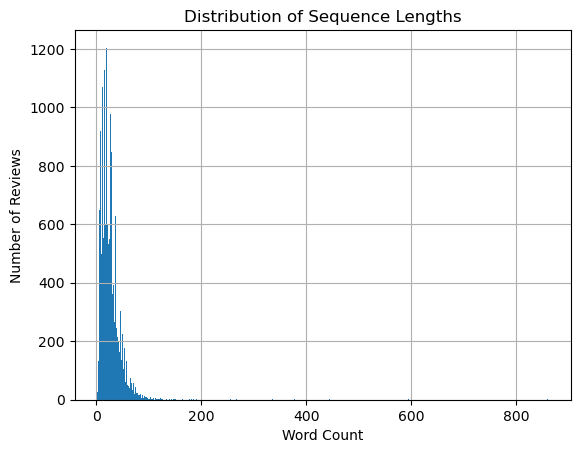

In [5]:
# Histogram of 'sequence_length'
ax = df['sequence_length'].hist(bins='auto')
ax.set_xlabel('Word Count')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Sequence Lengths');

- Mean length: 26.7
- Range length: 2 - 861

In [6]:
df['author'].value_counts(dropna=False)

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

# RandomUnderSampler
- Target is unblanced
- Using RandomUnderSampler to balance data based on 'author' column

In [7]:
# RandomUnderSampler to match minority group
sampler = RandomUnderSampler(random_state=42)
df, _ = sampler.fit_resample(df,df['author'])
df['author'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

# X, y
- Using .map to change 'author' column to numerical data and defineing it as y(target)

In [8]:
# Crate a map for targets
target_map = {'EAP' : 0, 'HPL' : 1, 'MWS' : 2}

# define y as target
y = df['author'].map(target_map)
y

id
id22483    0
id18809    0
id16322    0
id13423    0
id09553    0
          ..
id22356    2
id11504    2
id00149    2
id16796    2
id23776    2
Name: author, Length: 16905, dtype: int64

- Defining X as 'test' column

In [9]:
# X 
X = df['text'].values
X

array(['He then asked me, suddenly, if I had observed any thing peculiar at the scene of the atrocity.',
       'Through the exertions of Beauvais, the matter was industriously hushed up, as far as possible; and several days had elapsed before any public emotion resulted.',
       'The cold was intense, and obliged me to wrap up closely in an overcoat.',
       ...,
       'What I ask of you is reasonable and moderate; I demand a creature of another sex, but as hideous as myself; the gratification is small, but it is all that I can receive, and it shall content me.',
       'The birth of her daughter, embryo copy of her Raymond, filled up the measure of her content, and produced a sacred and indissoluble tie between them.',
       "I heard my sister's sobs, and thought, happy are women who can weep, and in a passionate caress disburthen the oppression of their feelings; shame and habitual restraint hold back a man."],
      dtype=object)

In [10]:
y.value_counts(normalize=True)

0    0.333333
1    0.333333
2    0.333333
Name: author, dtype: float64

In [11]:
classes = y.unique()
classes

array([0, 1, 2])

# Convert to dataset object using Dataset.from_tensor_slices()
- Shuffle the data

In [12]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X,y))

# Shuffle dataset
ds = ds.shuffle(buffer_size = len(df), reshuffle_each_iteration=False)

Metal device set to: Apple M1


# TTS
- train size = .7
- val size = .2
- test size = 1 - (train + val)
- Use batch size 31

In [13]:
# Set the ratio of train, val, and test split
split_train = .7
split_val = .2
split_test = 1 - (split_train + split_val)

# Calculate the number of samples for training, val and test data
n_train_samples = int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -  (n_train_samples + n_val_samples)

# Set Batch size
b_size = 32

import math 
# math.ceil will round up
# How many batches?
n_train_batch = math.ceil(n_train_samples/b_size)
n_val_batch = math.ceil(n_val_samples/b_size)
n_test_batch = math.ceil(n_test_samples/b_size)

print(f" - Train:\t{n_train_samples} samples \t({n_train_batch} batches)")
print(f' - Val: \t{n_val_samples} samples \t({n_val_batch} batches)')
print(f' - Test: \t{n_test_samples} samples \t({n_test_batch} batches)')

 - Train:	11833 samples 	(370 batches)
 - Val: 	3381 samples 	(106 batches)
 - Test: 	1691 samples 	(53 batches)


In [14]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=b_size)

# Skip over the training batches and take the val batches
val_ds = ds.skip(n_train_samples). take(n_val_samples).batch(batch_size=b_size)

# Slip over the train and val batches and the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=b_size)

In [15]:
# Confirm the number of batches in each
print(f'There are {len(train_ds)} training batches.')
print(f'There are {len(val_ds)} validation batches.')
print(f'There are {len(test_ds)} testing batches.')

There are 370 training batches.
There are 106 validation batches.
There are 53 testing batches.


# Text Vectorization
- Going to standardize to lower case and strip punctiuation.
- Uning 'int' for output_mode assing an interger to every specific word

In [16]:
# Create text Vectorization Layer
vectorizer = tf.keras.layers.TextVectorization(standardize="lower_and_strip_punctuation",
                                              output_mode='int',
                                              output_sequence_length=100)

In [17]:
# Get just the text from ds_train
ds_text = train_ds.map(lambda x,y: x)
ds_text.take(1).get_single_element()

2024-01-17 08:04:48.262889: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'And this was in truth the Death of which these bystanders spoke reverently, in low whispers you, sweet Una, gaspingly, with loud cries.',
       b'Had my eyes deceived me?',
       b"For some distance the line kept on along the gorge's brink, but at length I reached the long covered bridge where it crossed the chasm at a dizzy height.",
       b'The two forces mingling, unarmed and hand in hand, talking only how each might assist the other, the adversaries conjoined; each repenting, the one side their former cruelties, the other their late violence, they obeyed the orders of the General to proceed towards London.',
       b'I have already put off the carelessness of childhood, the unlined brow, and springy gait of early years, that they may adorn thee.',
       b'Idleness had ever been irksome to me, and now that I wished to fly from reflection, and hated my former studies, I felt great relief in being the fellow pupil with my frie

In [18]:
# Train (adapt on training text data)
vectorizer.adapt(ds_text)
v_size = vectorizer.vocabulary_size()
v_size

20976

In [19]:
# Getting list of vocab
vocab = vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'of',
 4: 'and',
 5: 'to',
 6: 'i',
 7: 'a',
 8: 'in',
 9: 'was',
 10: 'that',
 11: 'my',
 12: 'it',
 13: 'he',
 14: 'had',
 15: 'with',
 16: 'his',
 17: 'as',
 18: 'for',
 19: 'but',
 20: 'which',
 21: 'not',
 22: 'me',
 23: 'at',
 24: 'from',
 25: 'by',
 26: 'on',
 27: 'this',
 28: 'is',
 29: 'her',
 30: 'be',
 31: 'were',
 32: 'have',
 33: 'you',
 34: 'all',
 35: 'an',
 36: 'we',
 37: 'or',
 38: 'no',
 39: 'when',
 40: 'him',
 41: 'one',
 42: 'so',
 43: 'they',
 44: 'been',
 45: 'could',
 46: 'would',
 47: 'she',
 48: 'there',
 49: 'upon',
 50: 'more',
 51: 'its',
 52: 'their',
 53: 'now',
 54: 'what',
 55: 'some',
 56: 'our',
 57: 'into',
 58: 'if',
 59: 'them',
 60: 'who',
 61: 'are',
 62: 'will',
 63: 'than',
 64: 'then',
 65: 'only',
 66: 'very',
 67: 'up',
 68: 'before',
 69: 'man',
 70: 'about',
 71: 'even',
 72: 'these',
 73: 'out',
 74: 'yet',
 75: 'your',
 76: 'time',
 77: 'did',
 78: 'any',
 79: 'old',
 80: 'said',
 81: 'might',
 82: 'li

In [20]:
from pprint import pprint
def make_text_vectorization_layer(train_ds,  max_tokens=None, 
                                  split='whitespace',
                                  standardize="lower_and_strip_punctuation",
                                  output_mode="int",
                                  output_sequence_length=None,
                                  ngrams=None, pad_to_max_tokens=False,
                                  verbose=True,
                                  **kwargs,
                                 ):
    # Build the text vectorization layer
    text_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens,
        standardize=standardize, 
        output_mode=output_mode,
        output_sequence_length=output_sequence_length,
        **kwargs
    )
    # Get just the text from the training data
    if isinstance(train_ds, (np.ndarray, list, tuple, pd.Series)):
        ds_texts = train_ds
    else:
        try:
            ds_texts = train_ds.map(lambda x, y: x )
        except:
            ds_texts = train_ds
            
    # Fit the layer on the training texts
    text_vectorizer.adapt(ds_texts)
    
    
    if verbose:
        # Print the params
        print( "\ntf.keras.layers.TextVectorization(" )
        config = text_vectorizer.get_config()
        pprint(config,indent=4)
        print(")")
               
    # SAVING VOCAB FOR LATER
    # Getting list of vocab 
    vocab = text_vectorizer.get_vocabulary()
    # Save dictionaries to look up words from ints 
    int_to_str  = {idx:word for idx, word in enumerate(vocab)}
    
    return text_vectorizer, int_to_str


In [21]:
seq_length = 100

seq_vect, vocab_lookup = make_text_vectorization_layer(train_ds,output_mode = 'int',
                                                      output_sequence_length = seq_length,
                                                      verbose = True)


tf.keras.layers.TextVectorization(
{   'batch_input_shape': (None,),
    'dtype': 'string',
    'encoding': 'utf-8',
    'idf_weights': None,
    'max_tokens': None,
    'name': 'text_vectorization_1',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 100,
    'pad_to_max_tokens': False,
    'ragged': False,
    'sparse': False,
    'split': 'whitespace',
    'standardize': 'lower_and_strip_punctuation',
    'trainable': True,
    'vocabulary': None,
    'vocabulary_size': 20976}
)


In [22]:
#vocab_size = seq_vect.vocabulary_size()
vocab_size = len(seq_vect.get_vocabulary())
vocab_size

20976

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

def build_lstm_model(text_vectorization_layer):
    # Define sequential model with pre-trained vectorization layer and 'new' embedding layer
    lstm_model = Sequential([text_vectorization_layer, layers.Embedding(input_dim= vocab_size,
                                                                       output_dim = 150,
                                                                       input_length = seq_length)])

    #Add 'new' LSTM layer
    lstm_model.add(layers.LSTM(128))
    #Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))

    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01),
                      loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

    lstm_model.summary()
    return lstm_model

In [24]:
def get_callbacks(patience = 3, monitor = 'val_accuracy'):
    early_stop =  tf.keras.callbacks.EarlyStopping(patience = patience, monitor = monitor)
    return [early_stop]

In [25]:
def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict



In [26]:
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()



In [27]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs



In [28]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)



In [29]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 100, 150)          3146400   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 3,289,635
Trainable params: 3,289,635
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
370/370 [==============================] - 16s 40ms/step - loss: 1.1133 - accuracy: 0.3322 - val_loss

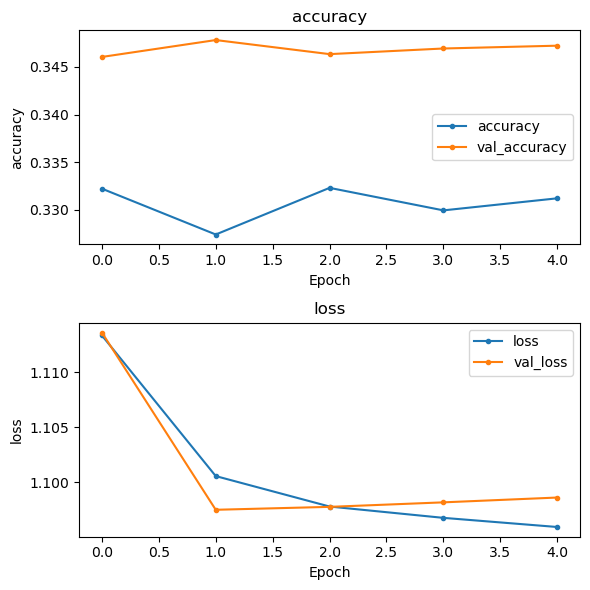


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      1.00      0.50      3906
           1       0.91      0.00      0.01      3952
           2       1.00      0.00      0.01      3975

    accuracy                           0.33     11833
   macro avg       0.75      0.34      0.17     11833
weighted avg       0.75      0.33      0.17     11833



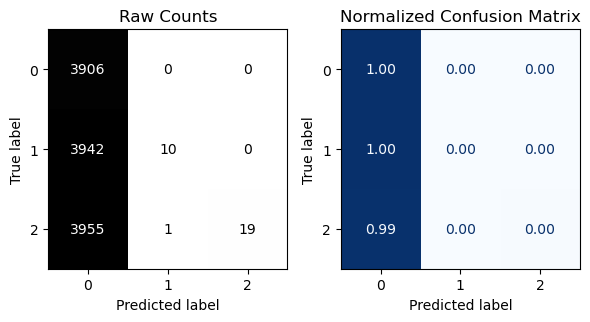


- Evaluating Training Data:
370/370 [==============================] - 4s 11ms/step - loss: 1.0946 - accuracy: 0.3325
{'loss': 1.0945621728897095, 'accuracy': 0.33254456520080566}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.33      1.00      0.50       559
           1       0.00      0.00      0.00       560
           2       0.33      0.00      0.00       572

    accuracy                           0.33      1691
   macro avg       0.22      0.33      0.17      1691
weighted avg       0.22      0.33      0.17      1691



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

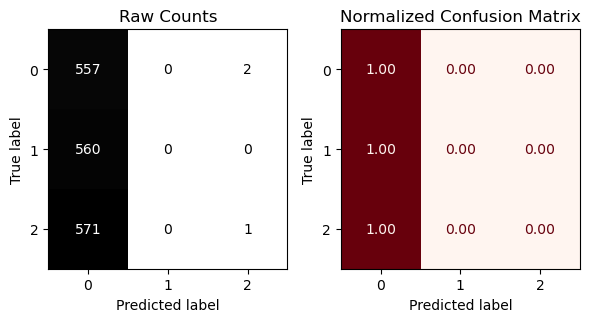


- Evaluating Test Data:
 6/53 [==>...........................] - ETA: 0s - loss: 1.0965 - accuracy: 0.3594

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

53/53 [==============================] - 1s 12ms/step - loss: 1.1050 - accuracy: 0.3300
{'loss': 1.1049572229385376, 'accuracy': 0.3299822509288788}


In [30]:
# build lstm model and specify the vectorizer
lstm_model = build_lstm_model(seq_vect)
# Define number of epocs
epochs = 30
# fit the model
history = lstm_model.fit(train_ds, epochs = epochs, validation_data = val_ds,
                        callbacks = get_callbacks())
# Obtain the results
results = evaluate_classification_network(lstm_model, X_train = train_ds, 
                                         X_test = test_ds, history = history);

# GRU

In [31]:
def build_gru_model(text_vectorization_layer):

    gru_model = Sequential([text_vectorization_layer, tf.keras.layers.Embedding(input_dim = vocab_size,
                                                                               output_dim =150,
                                                                               input_length = seq_length)])

    # Add GRU layer 'new'
    gru_model.add(layers.GRU(128, return_sequences=True))
    gru_model.add(layers.GlobalMaxPooling1D())
    # Dropout layer
    gru_model.add(layers.Dense(len(classes), activation='softmax'))

    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
    gru_model.summary()
    return gru_model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 100)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru (GRU)                   (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,254,307
Trainable params: 3,254,307
No

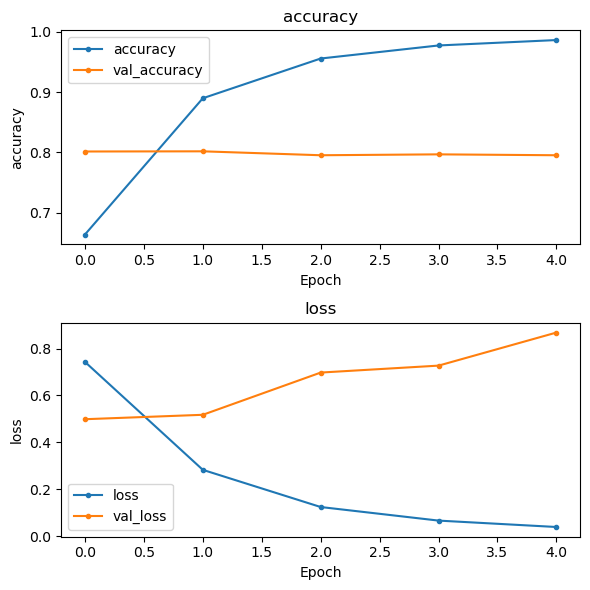


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3906
           1       1.00      0.99      1.00      3952
           2       0.99      1.00      1.00      3975

    accuracy                           1.00     11833
   macro avg       1.00      1.00      1.00     11833
weighted avg       1.00      1.00      1.00     11833



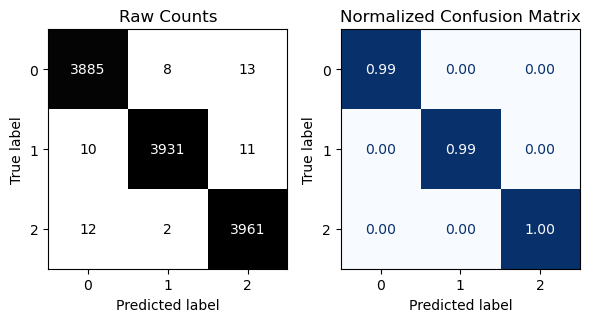


- Evaluating Training Data:
370/370 [==============================] - 4s 10ms/step - loss: 0.0176 - accuracy: 0.9953
{'loss': 0.017631489783525467, 'accuracy': 0.9952674508094788}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       559
           1       0.82      0.79      0.81       560
           2       0.80      0.86      0.82       572

    accuracy                           0.80      1691
   macro avg       0.80      0.80      0.80      1691
weighted avg       0.80      0.80      0.80      1691



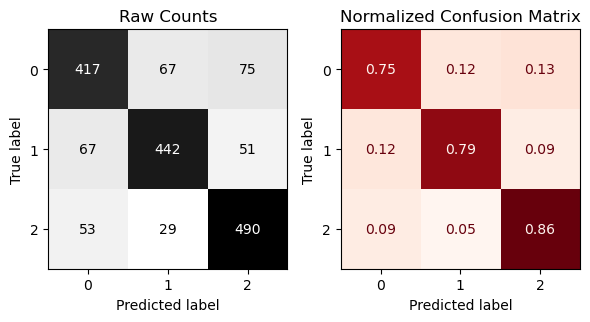


- Evaluating Test Data:
53/53 [==============================] - 1s 11ms/step - loss: 0.8464 - accuracy: 0.7978
{'loss': 0.846401572227478, 'accuracy': 0.7977527976036072}


In [32]:
# Build the model
model = build_gru_model(seq_vect)
#fit the model
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks = get_callbacks())
# Evaluate the model
results = evaluate_classification_network(model, X_train=train_ds, X_test = test_ds, 
                                         history = history);

# GRU Model was much better than the lstm